<a href="https://colab.research.google.com/github/Deepak2102-R/hello-world/blob/main/image_caption_for_covid_dataset_val_acc_86_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
# !unzip -q /content/covid19-radiography-database.zip

In [12]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
import os

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
covidDataPath='/content/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
pneumoniaDataPath='/content/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'
normalDataPath='/content/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
lungopacityDataPath = '/content/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity'

In [15]:
# Lists for access paths
listCovidPaths = []
listNormalPaths = []
listPneumoniaPaths = []
listLOPaths = []

# Get covid images files paths
for root, directories, files in os.walk(covidDataPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))
# Get Pneumonia images files paths
for root, directories, files in os.walk(pneumoniaDataPath):
    for name in files:
        listPneumoniaPaths.append(os.path.join(root, name))

# Get normal images files paths
for root, directories, files in os.walk(normalDataPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

# Get lung opacity images files paths
for root, directories, files in os.walk(lungopacityDataPath):
    for name in files:
        listLOPaths.append(os.path.join(root, name))


# Shuffle lists for random train / test

random.shuffle(listCovidPaths)
random.shuffle(listNormalPaths)
random.shuffle(listPneumoniaPaths)
random.shuffle(listLOPaths)

In [16]:
# main folder
!mkdir ./Data/

# Train data folders
!mkdir ./Data/Train/

# Valid data folders
!mkdir ./Data/Valid/

# Paths to train folders
pathTrain = './Data/Train/'

# Paths to valid folders
pathValid='./Data/Valid/'


In [17]:
from distutils.file_util import copy_file

In [18]:
"""
Moving files to new folders
"""


# Move covid images files to new folders
for i in range(7232):
    if i < 7232:
        copy_file(listCovidPaths[i], pathTrain)
    else  :
        copy_file(listCovidPaths[i], pathValid)

for i in range(20384):
    if i < 20384:
        copy_file(listNormalPaths[i], pathTrain)
    else  :
        copy_file(listNormalPaths[i], pathValid)

for i in range(2690):
    if i < 2690:
        copy_file(listPneumoniaPaths[i], pathTrain)
    else  :
        copy_file(listPneumoniaPaths[i], pathValid)

for i in range(12024):
    if i < 12024:
        copy_file(listLOPaths[i], pathTrain)
    else  :
        copy_file(listLOPaths[i], pathValid)

In [19]:
with open('/content/input/crd-caption/train_captions.json', 'r') as f:
    captions = json.load(f)

In [20]:
img_cap_pairs = []
for image_path, caption_info in captions.items():
    img_name = os.path.basename(image_path)
    img_cap_pairs.append([img_name, caption_info['caption']])

In [21]:
captions_df = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

In [22]:
dataPath = pathTrain
captions_df['image'] = captions_df['image'].apply(lambda x: os.path.join(dataPath, x))

In [23]:
print(captions_df.shape)

(15153, 2)


In [24]:
captions_df = captions_df.sample(12000)
captions_df = captions_df.reset_index(drop=True)

In [25]:
captions_df.head()

,image,caption
0,./Data/Train/Normal-5501.png,The respiratory system is normal in this case.
1,./Data/Train/Normal-6333.png,This is an example of a healthy respiratory sy...
2,./Data/Train/COVID-802.png,The patient is diagnosed with Covid.
3,./Data/Train/Viral Pneumonia-163.png,The patient is diagnosed with pneumonia.
4,./Data/Train/Viral Pneumonia-408.png,This scenario involves bacterial pneumonia.


In [26]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [27]:
captions_df['caption'] = captions_df['caption'].apply(preprocess)
captions_df.head()

,image,caption
0,./Data/Train/Normal-5501.png,[start] the respiratory system is normal in th...
1,./Data/Train/Normal-6333.png,[start] this is an example of a healthy respir...
2,./Data/Train/COVID-802.png,[start] the patient is diagnosed with covid [end]
3,./Data/Train/Viral Pneumonia-163.png,[start] the patient is diagnosed with pneumoni...
4,./Data/Train/Viral Pneumonia-408.png,[start] this scenario involves bacterial pneum...


In [28]:
# dataPath = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset', 'COVID', 'Viral Pneumonia', 'Normal', 'Lung_Opacity')
# captions_df['image'] = captions_df['image'].apply(lambda x: os.path.join(dataPath, x))

In [29]:
import matplotlib.pyplot as plt
import cv2

In [30]:
idx = 42  # Replace with your desired index
sample_row = captions_df.iloc[idx]

In [31]:
image_path = sample_row['image']
image = cv2.imread('/content/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-10.png')

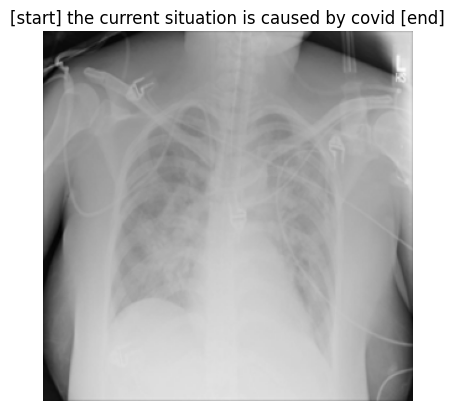

In [32]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(sample_row['caption'])
plt.axis('off')
plt.show()

In [33]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 150
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 15
steps_per_epoch= 100

In [34]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions_df['caption'])

In [35]:
tokenizer.vocabulary_size()

95

In [36]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_CRD.file', 'wb'))

In [37]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [38]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions_df['image'], captions_df['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [39]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(9600, 9600, 2400, 2400)

In [40]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [42]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [43]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9)

In [44]:
def CNN_Encoder():
    # Load pre-trained Xception model
    base_model = tf.keras.applications.efficientnet.EfficientNetB7(
        include_top=False,
        weights='imagenet',
        pooling=max,
        classifier_activation='softmax'
    )

    # Fine-tune the pre-trained model on your dataset
    for layer in base_model.layers:
        layer.trainable = True

    # Add batch normalization layers
    x = base_model.output
    x = tf.keras.layers.BatchNormalization()(x)

    # Add dropout layers
    x = tf.keras.layers.Dropout(0.5)(x)

    # Reshape output
    x = tf.keras.layers.Reshape((-1, x.shape[-1]))(x)

    # Define model
    cnn_model = tf.keras.models.Model(base_model.input, x)

    return cnn_model

In [45]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [46]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [47]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [48]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


#     def build(self, input_shape=None):
#         if input_shape is None:
#             input_shape = self.input_shape

#         self.cnn_model.build(input_shape)
#         self.encoder.build((None, self.cnn_model.output_shape[1], self.cnn_model.output_shape[2], self.cnn_model.output_shape[3]))
#         self.decoder.build((None, None, self.encoder.output_shape[-1]))
#         super().build(input_shape)

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [49]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

258076736/258076736 [==============================] - 12s 0us/step


In [50]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [51]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/15
150/150 [==============================] - 340s 2s/step - loss: 1.0687 - acc: 0.5691 - val_loss: 0.4905 - val_acc: 0.8428
Epoch 2/15
150/150 [==============================] - 303s 2s/step - loss: 0.4554 - acc: 0.8427 - val_loss: 0.4473 - val_acc: 0.8510
Epoch 3/15
150/150 [==============================] - 274s 2s/step - loss: 0.4160 - acc: 0.8522 - val_loss: 0.3958 - val_acc: 0.8514
Epoch 4/15
150/150 [==============================] - 302s 2s/step - loss: 0.3952 - acc: 0.8547 - val_loss: 0.3980 - val_acc: 0.8495
Epoch 5/15
150/150 [==============================] - 302s 2s/step - loss: 0.3886 - acc: 0.8562 - val_loss: 0.3847 - val_acc: 0.8579
Epoch 6/15
150/150 [==============================] - 272s 2s/step - loss: 0.3814 - acc: 0.8600 - val_loss: 0.3991 - val_acc: 0.8526
Epoch 7/15
150/150 [==============================] - 303s 2s/step - loss: 0.3866 - acc: 0.8561 - val_loss: 0.3788 - val_acc: 0.8552
Epoch 8/15
150/150 [==============================] - 273s 2s/step - 

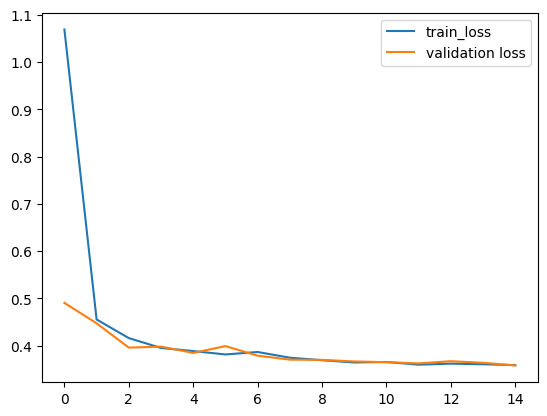

In [52]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [53]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)

    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))

    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: the patient is diagnosed with covid



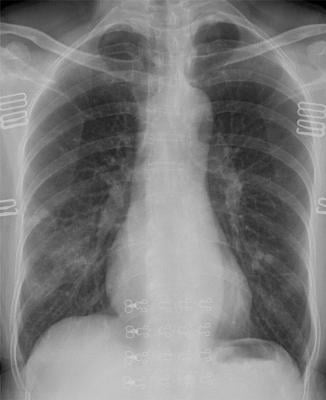

In [54]:
img_url = "https://www.itnonline.com/sites/default/files/styles/content_large/public/Chest.jpeg?itok=6lDKVuVn"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [55]:
caption_model.save_weights('CRD_effnet_Trn_LSTM.h5')

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [57]:
checkpoint_callback = ModelCheckpoint(
    "/kaggle/working/Data/CRD_effnet_Trn_LSTM.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1,
)

In [58]:
New_Epoch = 10

In [59]:
history1 = caption_model.fit(
    train_dataset,
    epochs=New_Epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.3582 - acc: 0.8633
Epoch 1: val_loss improved from inf to 0.35984, saving model to /kaggle/working/Data/CRD_effnet_Trn_LSTM.h5
150/150 [==============================] - 280s 2s/step - loss: 0.3582 - acc: 0.8633 - val_loss: 0.3598 - val_acc: 0.8613
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.3605 - acc: 0.8628
Epoch 2: val_loss did not improve from 0.35984
150/150 [==============================] - 302s 2s/step - loss: 0.3605 - acc: 0.8628 - val_loss: 0.3637 - val_acc: 0.8615
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.3580 - acc: 0.8627
Epoch 3: val_loss did not improve from 0.35984
150/150 [==============================] - 303s 2s/step - loss: 0.3580 - acc: 0.8627 - val_loss: 0.3660 - val_acc: 0.8597
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.3571 - acc: 0.8638
Epoch 4: val_loss did not improve from 0.35984
150/150 [============

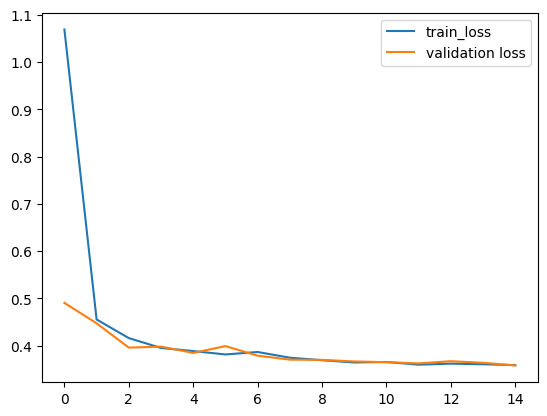

In [60]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [61]:
caption_model.save_weights('CRD_effnet_Trn_LSTM.h5')